# 卷积神经网络应用
使用tensorflow实现一个功能完全的卷积神经网络

建立和训练一个卷积神经网络对于分类问题

## 1.0 tensorflow模型

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


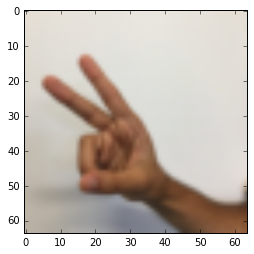

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 1.1 创建占位符
tensorflow要求为喂入模型的输入数据创建占位符，不应该定义好训练样本的数量，所以使用None表示不确定的batch size，可以使得后面更加灵活。

In [5]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(name="X",shape=(None,n_H0, n_W0, n_C0),dtype=tf.float32)
    Y = tf.placeholder(name="Y",shape=(None,n_y),dtype=tf.float32)
    ### END CODE HERE ###
    
    return X, Y

In [6]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 6), dtype=float32)


## 1.2 初始化参数
需要初始化权重或者说过滤器，W1 W2使用tf.contrib.layers.xavier_initializer(seed = 0). 
你不需要考虑b参数，因为tensorflow会照顾好这个偏置。并且你仅初始化参数W为这个conv2d函数中。tensorflow自动初始化完全连接的层。

初始化过滤器使用的代码：
W = tf.get_variable("W", [1,2,3,4], initializer = ...)

In [7]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1",[4,4,3,8],dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [8]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## 1.2 前向传播
在tensorflow中，有内置函数可以执行卷积操作。

1. tf.nn.conv2d(X,W1,strides=[1,s,s,1],padding = 'SAME'):在给定的输入以及一组过滤器W1，这个函数就会在X上进行W1个过滤器的卷积操作。第三个参数strides=[1,s,s,1]表示了在X的每一个维度上的步长，这里在第一维上为1其实就是训练样本一个个看，s，s表示在原始图片的长和宽的步长，后面的1是因为filter和原始图片的通道数一样，自然就是1的步长。

2. tf.nn.max_pool(A,ksize=[1,f,f,1], strides=[1,s,s,1],padding = 'SAME'):表示在给定输入A情况下，这个函数使用大小为（f，f）的窗口，并且以步长为（s,s）在每个窗口上执行最大池化操作。

3. tf.nn.relu(Z1):计算关于Z1的激活值

4. tf.contrib.layers.flatten(P):表示给定输入P，这个函数把每一个样本展开成1维向量，当维持batch_size时候，但会一个平展开的tensor张量，并且维度为[batch_size,k]

5. tf.contrib.layers.fully_connected(F,num_outputs):给定一个平展开的向量F，返回计算好的结果并且使用全连接层

关于tf.contrib.layers.fully_connected(F,num_outputs),全连接层会自动初始化权重在图里面，并且在模型上训练这些参数。因此，不需要为全连接层初始化参数。

练习：
实现正向传播函数，并且使用下面这个模型：
`CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`你将会使用到上面那些函数。

细节上，我们会在所有步骤中使用到下面这些参数：

 - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 
     最后一层是全连接层，但是因为最后我们要使用的是softmax分类器，在前面我们学到过，使用softmax分类器的时候，倒数那一层不需要计算出激活值，只需要计算到z就可以了，所以不要使用非线性激活函数。activation_fn = None

In [9]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=(1,1,1,1),padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize=(1,8,8,1), strides=(1,8,8,1),padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=(1,1,1,1),padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=(1,4,4,1), strides=(1,4,4,1),padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn = None)
    #activation_fn = None一定不能少，这里是最大池化层结束后，接上一个全连接层，直接是softmax层，所以这一层连接好后
    #根据softmax使用要求，不需要计算激活函数值
    ### END CODE HERE ###

    return Z3

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[-0.44670227 -1.5720876  -1.5304923  -2.3101304  -1.2910438   0.46852064]
 [-0.17601591 -1.5797201  -1.4737016  -2.616721   -1.0081065   0.5747785 ]]


## 1.3 计算损失

tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):这里使用tf内置的关于softmax分类的计算cost，所以输入内容为Z3，而不是激活值A3.

tf.reduce_mean：计算平均值。使用上面的和除以所有样本数得到全局损失

In [11]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 2.9103398


## 1.4 模型
最后你将要把所有的辅助函数都合在一起建立一个模型，在手势数据及上进行训练。

在第二门课已经实现过随机批量化，random_mini_batches()，记得这个函数是返回一个mini-batches的列表，列表里的每个元素是一个批量元组，包括训练集的X和训练集对应的Y。

那么接下来实现model参数：
1. 创建占位符
2. 初始化参数
3. 前向传播
4. 计算损失
5. 选择一个优化器

最后就创建session并且为num_Pochs创建循环，并且取得最小批，对每一个批量都来优化函数。

In [13]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y =  create_placeholders(n_H0, n_W0, n_C0,n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X,parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost =  sess.run([optimizer,cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.917920
Cost after epoch 5: 1.532475
Cost after epoch 10: 1.014804
Cost after epoch 15: 0.885137
Cost after epoch 20: 0.766963
Cost after epoch 25: 0.651208
Cost after epoch 30: 0.613356
Cost after epoch 35: 0.605931
Cost after epoch 40: 0.534713
Cost after epoch 45: 0.551402
Cost after epoch 50: 0.496976
Cost after epoch 55: 0.454438
Cost after epoch 60: 0.455496
Cost after epoch 65: 0.458359
Cost after epoch 70: 0.450040
Cost after epoch 75: 0.410687
Cost after epoch 80: 0.469005
Cost after epoch 85: 0.389253
Cost after epoch 90: 0.363808
Cost after epoch 95: 0.376132


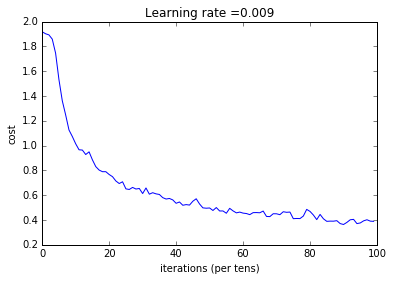

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.86851853
Test Accuracy: 0.73333335


In [14]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

关于最后测试的结果跟预期输出结果不一样，原因可能有：（1）使用的是cpu还是gpu环境，我使用的cpu，并且换了好几个tensorflow的版本，在计算cost时，结果为cost = 2.9103398，而gpu上cost=2.91034   （2）tensorflow的版本，猜测可能是有些地方的随机种子设置的不一样吧，最后的运行结果有误差，使用gpu运行出来，尽管有偏差，也是90多正确率训练结果，80多测试正确率结果

D:\softpath\Anaconda2\envs\py3\lib\site-packages\scipy\misc\pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
D:\softpath\Anaconda2\envs\py3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


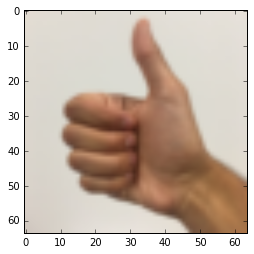

In [15]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)